# Lab 6: Sentiment Analysis with fine-tuned Transformers

In this lab session, you will fine-tune a **Transformer** based pre-trained language model for sentiment analysis. Transfer learning with large pre-trained language models has been shown to be successful strategy to achieve state-of-the-art performances. In this lab we'll learn how to do transfer learning with large pre-trained neural language models like BERT. 

More concretely, in this lab session will learn the following:

- Deploy and fine-tune transformers from the [Hugging Face library](https://github.com/huggingface/transformers)
- Preprocessing data for transformers archicture (word piece tokenization)
- Implementation of Transformer-based classifier



----

## Transfer Learning
 
Figure below shows how to fine-tune a transformer on a downstream task. Here, the fine-tuning task is sentiment analysis of movie reviews. As learned from theory, we will use the knowledge encoded in the Transformer to learn better our target task. So our sentiment classifier has two main components: 1) the text encoder based on BERT (which doesn't know anything about sentiments, but knows something about English), and 2) the component dedicated to sentiment classification (a simple feed-forward layer). In other words, BERT will generate the sentence embeddings of the input and pass to the classifier layer to the prediction. When we fine-tune our classifier we'll change BERT's parameters as well, and make it to learn specific aspects of the task.

 ![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/fine-tuning.png)


Advantages of these types of architectures and learning:

- Unlimited amount of unlabelled text data can be scraped from the web with very little effort to train a large language model.
- Transformer is a feed-forward architecture that allows highly parallelized, efficient training on huge datasets, with the objective of simply predicting words based on their context ([check the tutorial on strategy learning for sequence classification](https://colab.research.google.com/drive/1yWaLpCWImXZE2fPV0ZYDdWWI8f52__9A#scrollTo=MGqVkG2-7qfu)).
- Although pre-training a language model can be expensive, fine-tuning can be done in a single GPU most of the times, as tipically it requiere few learning epochs. 


## 1. Loading the data
We'll use the same data for sentiment analysis used in previous sessions. So first, we need to mount our Drive account in order to get access to the sentiment analysis data ( Stanford Sentiment Treebank).

In [ ]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
from sklearn.utils import shuffle

## for replicability of results
np.random.seed(1)
tf.random.set_seed(2)

# Let's do 2-way positive/negative classification instead of 5-way    
def load_sst_data(path,
                  easy_label_map={0:0, 1:0, 2:None, 3:1, 4:1}):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)
    data = pd.DataFrame(data)
    return data

def pretty_print(example):
    print('Label: {}\nText: {}'.format(example['label'], example['text']))

sst_home = 'data/trees/'
training_set = load_sst_data(sst_home+'/train.txt')
dev_set = load_sst_data(sst_home+'/dev.txt')
test_set = load_sst_data(sst_home+'/test.txt')

# Shuffle dataset
training_set = shuffle(training_set)
dev_set = shuffle(dev_set)
test_set = shuffle(test_set)

# Obtain text and label vectors
train_texts = training_set.text
train_labels = training_set.label

dev_texts = dev_set.text
dev_labels = dev_set.label

test_texts = test_set.text
test_labels = test_set.label


print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

Training size: 6920
Dev size: 872
Test size: 1821


## 2. Installing and seting up the Transformers library

In [4]:
# https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html
!pip install transformers

     |████████████████████████████████| 3.4 MB 8.0 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 895 kB 73.7 MB/s 
     |████████████████████████████████| 596 kB 67.5 MB/s 
     |████████████████████████████████| 3.3 MB 41.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Once the transformers library is installed, we can use it directly just creating three object of two classes:

- **The tokenizer class**: the tokenizer class takes care of converting input  string in tensors of integers which are indices in a model vocabulary. The tokenization varies according to the model, therefore each model has its own tokenizer.

- **The model class**: the model class holds the neural network modeling logic itself. When using a TensorFlow model, it inherits from tf.keras.layers. Layer which means it can be used very simply by the Keras’ fit API or make more complicated stuff. 

There is also **configuration class** that is also required unless you are not using the default values. With the configuration class we indicate everything related to hyperparaters such as number of layers, dropout and so on. Below is an example of a BERT configuration file, for the pre-trained weights bert-base-cased. 

```
{
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 28996
}
```


In [5]:
from transformers import TFBertForSequenceClassification, BertTokenizer

model = TFBertForSequenceClassification.from_pretrained("bert-base-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Next we will define two helper function to 1) extract features from the tokenizer (`convert_examples_to_features`) and 2) convert the features to `tf.data.Dataset` object class (`convert_features_to_tf_dataset`). `tf.data.Dataset` is a convinient API that helps managing and iterating in efficient way the input and output data of the model.  For more information you can check the API in tensorflow web page: https://www.tensorflow.org/api_docs/python/tf/data/Dataset.

In [6]:
from transformers import InputFeatures

def convert_examples_to_features(texts, labels):
  labels = list(labels)
  batch_encoding = tokenizer.batch_encode_plus(texts, max_length=128, padding="max_length")

  features = []
  for i in range(len(texts)):
      inputs = {k: batch_encoding[k][i] for k in batch_encoding}

      feature = InputFeatures(**inputs, label=labels[i])
      features.append(feature)

  for i, example in enumerate(texts[:5]):
      print("*** Example ***")
      print("text: %s" % (example))
      print("features: %s" % features[i])

  return features

def convert_features_to_tf_dataset(features):
  def gen():
      for ex in features:
          yield (
              {
                  "input_ids": ex.input_ids,
                  "attention_mask": ex.attention_mask,
                  "token_type_ids": ex.token_type_ids,
              },
              ex.label,
          )
  dataset = tf.data.Dataset.from_generator(gen, 
                                           ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
                                           (
                                               {
                                                "input_ids": tf.TensorShape([None]),
                                                "attention_mask": tf.TensorShape([None]),
                                                "token_type_ids": tf.TensorShape([None])
                                                },
                                            tf.TensorShape([]),
                                            ))
  return dataset

Let's preprocess the training and development sets. Note that we use the `tf.data.Dataset` API to set the batch size to 32.

In [7]:
train_features = convert_examples_to_features(train_texts, train_labels)
train_dataset = convert_features_to_tf_dataset(train_features)

dev_features = convert_examples_to_features(dev_texts, dev_labels)
dev_dataset = convert_features_to_tf_dataset(dev_features)

train_dataset = train_dataset.shuffle(100).batch(32)
dev_dataset = dev_dataset.batch(32)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


*** Example ***
text: It is dark , brooding and slow , and takes its central idea way too seriously .
features: InputFeatures(input_ids=[101, 1135, 1110, 1843, 117, 9304, 13465, 1158, 1105, 3345, 117, 1105, 2274, 1157, 2129, 1911, 1236, 1315, 5536, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0,

The results of the tokenizer can be seen in the cell below. There are some differences if vary the tokenizer, but most of them provide the following information. 

- `input_ids`: list of token ids to be fed to a model. Remember that the tokens are subwords, and new tokens are included to indicate sentence separation or ending (`[SEP]`) as well as `[CLS]` token that allow the sentence classification .

- `token_type_ids`: list of token type ids to be fed to a model. 

- `attention_mask`: list of indices specifying which tokens should be attended to by the model


In [8]:
# take one batch of 32 examples.
instance = list(train_dataset.take(1).as_numpy_iterator())
print(instance)

[({'input_ids': array([[  101,  1135,   112, ...,     0,     0,     0],
       [  101, 19143,  1200, ...,     0,     0,     0],
       [  101,  1409,  1175, ...,     0,     0,     0],
       ...,
       [  101,  9352, 24851, ...,     0,     0,     0],
       [  101,  2409,  1157, ...,     0,     0,     0],
       [  101,  2268, 12062, ...,     0,     0,     0]], dtype=int32), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}, array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1]))]


## 3. Understanding the tokenizer

When we preprocess the input text to be fed in BERT like encoder, we tipically make three steps: 

1. Break words into tokens (subwords). 
2. Add the special tokens such as `[CLS]` and `[SEP]`. These special tokens are already included in the model's vocabulary, so they have their own token id.
3. Substitute the tokens with their corresponding ids. After this step will get the proper shape for BERT. 

The code cell bellow shows the results of the three steps. 




In [9]:
sentence1 = "a visually stunning rumination on love."
sentence2 = "There ought to be a directing license, so that Ed Burns can have his revoked."

# Tokenize sentence
sentence1_tokenized = tokenizer.tokenize(sentence1)
print('0. INPUT SENTENCE: {}'.format(sentence1))
print('1. TOKENIZED SENTENCE: {}'.format(sentence1_tokenized))

# Add Special tokens
sentence1_tokenized_with_special_tokens = ['[CLS]'] + sentence1_tokenized + ['[SEP]']
print('2. ADD [CLS], [SEP]: {}'.format(sentence1_tokenized_with_special_tokens))
sentence1_ids = tokenizer.convert_tokens_to_ids(sentence1_tokenized_with_special_tokens)

# Convert to ids
print('3. SENTENCE IDS: {}'.format(sentence1_ids))

0. INPUT SENTENCE: a visually stunning rumination on love.
1. TOKENIZED SENTENCE: ['a', 'visually', 'stunning', 'r', '##umi', '##nation', 'on', 'love', '.']
2. ADD [CLS], [SEP]: ['[CLS]', 'a', 'visually', 'stunning', 'r', '##umi', '##nation', 'on', 'love', '.', '[SEP]']
3. SENTENCE IDS: [101, 170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119, 102]


### Exercise 1:
- Can you see what happened to "rumination" after the tokenization? It was divided into 3 tokens: r, ##umi and ##nation.
- Can you identify the token ids for [CLS] and [SEP]? The ids for [CLS] and [SEP] are 101 and 102.

-----

The three steps can be done with `encode` or `batch_encode_plus` functions. The first function takes single string and convert is to ids. Then second function is more convinient to preprocess larger input data. It returns all the requiered information (input_ids, token_type_ids, attention_mask, etc) in a python dictionary. 

In [11]:
# how tokenize and get the token ids with one funtions
sentence1_ids = tokenizer.encode(sentence1, add_special_tokens=True)

print('SENTENCE IDS: {}'.format(sentence1_ids))

# there are more convinient methods to preprocess the input data. 
batch_encoding = tokenizer.batch_encode_plus(
        [sentence1], max_length=128, padding="max_length",
    )
print('ENCODE PLUS: {}'.format(batch_encoding))

SENTENCE IDS: [101, 170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119, 102]
ENCODE PLUS: {'input_ids': [[101, 170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0

### Two sentences as input

As you have seen in the theoretical part BERT is a masked language models that learns predicting masked words, and in addition it predicts if next sentence belongs after the first one. That's why BERT's tokenizer is ready to have two sentences as input. This way preprocessing the data is interesting for task like Semantic Textual Similiraty and Natural Language Inference. 

In [13]:
# how tokenize and get the token ids with one funtions
sentence_pair_ids = tokenizer.encode(text=sentence1, text_pair=sentence2, add_special_tokens=True)


# there are more convinient methods to preprocess the input data. 
batch_encoding = tokenizer.batch_encode_plus(
        [(sentence1, sentence2)], max_length=128, padding="max_length",
    )

print("SENTENCE PAIR IDS: {}".format(sentence_pair_ids))

SENTENCE PAIR IDS: [101, 170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119, 102, 1247, 11454, 1106, 1129, 170, 10404, 5941, 117, 1177, 1115, 5316, 9608, 1169, 1138, 1117, 25538, 119, 102]


### Exercise 2:
- From the IDs can you say which ids correspond to the first sentence and which to the second one? 

IDs before the first 102 ([SEP]) correspond to the first sentence: [101, 170, 19924, 15660, 187, 14088, 9199, 1113, 1567, 119, 102]

IDs after the first 102 ([SEP]) correspond to the second sentence: [1247, 11454, 1106, 1129, 170, 10404, 5941, 117, 1177, 1115, 5316, 9608, 1169, 1138, 1117, 25538, 119, 102]

## 4. Fine-tune BERT as Sentence Classifier

In [14]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = model.fit(train_dataset, epochs=3, validation_data=dev_dataset)

Epoch 1/3
217/217 [==============================] - 196s 797ms/step - loss: 0.3743 - accuracy: 0.8361 - val_loss: 0.2422 - val_accuracy: 0.9071
Epoch 2/3
217/217 [==============================] - 175s 807ms/step - loss: 0.1535 - accuracy: 0.9464 - val_loss: 0.2856 - val_accuracy: 0.9002
Epoch 3/3
217/217 [==============================] - 179s 825ms/step - loss: 0.0590 - accuracy: 0.9806 - val_loss: 0.4036 - val_accuracy: 0.8922


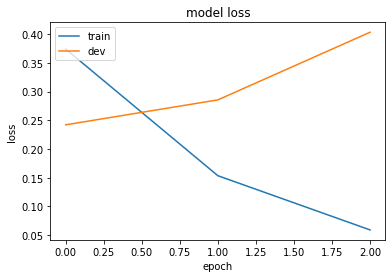

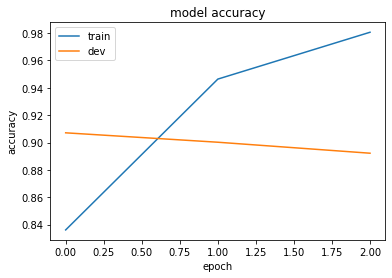

In [15]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

A nice feature when fine-tuning a large model is that we do not need to train many epochs (the number of epochs depends on the size of the training set). In this case, it looks like just one epoch can be enough. 

Once the model is fine-tuned for sentiment analysis we could evaluate it on the test set. In this we need to tokenized and convert to ids the input too. 

In [16]:
test_features = convert_examples_to_features(test_texts, test_labels)
test_dataset = convert_features_to_tf_dataset(test_features)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


*** Example ***
text: With Danilo Donati 's witty designs and Dante Spinotti 's luscious cinematography , this might have made a decent children 's movie -- if only Benigni had n't insisted on casting himself in the title role .
features: InputFeatures(input_ids=[101, 1556, 21555, 2858, 1790, 11745, 112, 188, 20787, 2340, 5054, 1105, 9406, 22878, 15719, 1182, 112, 188, 181, 1361, 9589, 7678, 22556, 117, 1142, 1547, 1138, 1189, 170, 11858, 1482, 112, 188, 2523, 118, 118, 1191, 1178, 3096, 11368, 1182, 1125, 183, 112, 189, 6744, 1113, 9616, 1471, 1107, 1103, 1641, 1648, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,

In [17]:
test_dataset = test_dataset.batch(32)
instances = list(test_dataset.take(1).as_numpy_iterator())
instances

[({'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          ...,
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0],
          [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
   'input_ids': array([[  101,  1556, 21555, ...,     0,     0,     0],
          [  101,  2397,  1273, ...,     0,     0,     0],
          [  101, 11300, 11179, ...,     0,     0,     0],
          ...,
          [  101,   146,  4819, ...,     0,     0,     0],
          [  101, 26517,  8743, ...,     0,     0,     0],
          [  101,  1109,  2905, ...,     0,     0,     0]], dtype=int32),
   'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=int32)},
  array([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
         0,

In [18]:
model.evaluate(test_dataset)

57/57 [==============================] - 15s 267ms/step - loss: 0.3453 - accuracy: 0.9044


[0.3452678918838501, 0.9044480919837952]

## 5. Fine-tuning BERT for NLI

Now that you know how to fine-tune BERT model for sentence classification. We could do something similar to fine-tune BERT to Natural Language Inference task. Recall that NLI consist in determining whether a natural language hypothesis can justifiably be inferred from a natural language premise hus given a pair of premise and hypothesis texts, the task is to classify them into three categories: entailment, contradiction, and neutral.

There are many ways to approach the task, but one way is to encode the premise and hypothesis at the same time as shown in the figure below. We separate premise and hypothesis sentences with `[SEP]` and use `[CLS]` token to perform the three-way classification task. 


 ![](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/bert_nli.png)

----



Let's start loading the data for NLI. We'll use the same function used in the previous lab.

In [19]:
import re
import random
import json
import bz2
import pandas as pd

def load_snli_data(path, label_map = {"entailment": 0, "neutral": 1,"contradiction": 2}):
    data = []
    with bz2.open(path) as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8')
            if i >= 1000000:  # Edit to use less data for debugging. set to 1000000 for testing.
                break
            json_line = json.loads(line)
            if json_line["gold_label"] not in label_map:
                continue
            loaded_example = {}
            loaded_example["label"] = label_map[json_line["gold_label"]]
            loaded_example["sentence1"] = json_line["sentence1"]
            loaded_example["sentence2"] = json_line["sentence2"]
            data.append(loaded_example)
    data = pd.DataFrame(data)
    return data

snli_home = 'data/snli/'  
training_set = load_snli_data(snli_home + '/snli_1.0_train.jsonl.bz2')
dev_set = load_snli_data(snli_home + '/snli_1.0_dev.jsonl.bz2')
test_set = load_snli_data(snli_home + '/snli_1.0_test.jsonl.bz2')

We are going to reduce the dataset to speed up the experiments in the lab session, but feel free to use the whole dataset after the lab is completed. Fine-tuning with the whole training set can take many hours, so maybe it is a good idea to run just for one or two epochs.


In [20]:
training_set = training_set.head(5000)
dev_set = dev_set.head(1000)

# check if the dataset is still balanced
print('Training labels:')
print(training_set.label.value_counts())

print('Dev labels:')
print(dev_set.label.value_counts())

Training labels:
0    1673
2    1669
1    1658
Name: label, dtype: int64
Dev labels:
2    336
1    333
0    331
Name: label, dtype: int64


Note that when we load the pretrained model (`from_pretrained`) we need to indicate number of labels that contains the dataset. This can be done with the argument `num_labels`.

In [21]:
from transformers import TFBertForSequenceClassification, BertTokenizer

nli_model = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


As you can see, the `config` has slightly changed compared to first model. Now it contains the information of the labels (we don't care about the actual id2label mapping for now).

In [22]:
nli_model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

### Exercise 3:
For the final exercise you have to re-write the function `convert_examples_to_features` so it is able to extract the token ids of premise and hypothesis in one go. Most of the function is already done for you. You just need to fill a small part to complete it.

In [23]:
import tensorflow as tf
from transformers import InputFeatures

def convert_nli_examples_to_features(premises, hypotheses, labels):
    labels = list(labels)

    # TODO: You need to create the code that fills the batch_encoding object. 
    # Hint: Iterate over premises and hypothesis to get tuples of 
    #       premises and hypotheses.
    pairs = []
    for i in range(len(premises)):
        pairs.append((premises[i], hypotheses[i]))
    batch_encoding = tokenizer.batch_encode_plus(pairs, max_length=128, padding="max_length")

    features = []
    for i in range(len(premises)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i in range(5):
        print("*** Example ***")
        print("premise: %s" % (premises[i]))
        print("hypothesis: %s" % (hypotheses[i]))
        print("features: %s" % features[i])

    return features

Once you complete the exercise you can see convert dataset to features first and to `tf.dataset` after that.

In [24]:
train_features = convert_nli_examples_to_features(training_set.sentence1, training_set.sentence2, training_set.label)
dev_features = convert_nli_examples_to_features(dev_set.sentence1, dev_set.sentence2, dev_set.label)

*** Example ***
premise: A person on a horse jumps over a broken down airplane.
hypothesis: A person is training his horse for a competition.
features: InputFeatures(input_ids=[101, 138, 1825, 1113, 170, 3241, 15457, 1166, 170, 3088, 1205, 15478, 119, 102, 138, 1825, 1110, 2013, 1117, 3241, 1111, 170, 2208, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [25]:
train_dataset = convert_features_to_tf_dataset(train_features)
dev_dataset = convert_features_to_tf_dataset(dev_features)

We use `tf.dataset` API to shuffle the training set and set the batch size. We decrease the batch size to 16 in order to avoid problems with the memory. 

In [26]:
train_dataset = train_dataset.shuffle(100).batch(16)
dev_dataset = dev_dataset.batch(32)

In [27]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
nli_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = nli_model.fit(train_dataset, epochs=3, validation_data=dev_dataset)

Epoch 1/3
313/313 [==============================] - 156s 435ms/step - loss: 0.8055 - accuracy: 0.6432 - val_loss: 0.5857 - val_accuracy: 0.7710
Epoch 2/3
313/313 [==============================] - 138s 442ms/step - loss: 0.4641 - accuracy: 0.8326 - val_loss: 0.5930 - val_accuracy: 0.7960
Epoch 3/3
313/313 [==============================] - 140s 449ms/step - loss: 0.2831 - accuracy: 0.9098 - val_loss: 0.6942 - val_accuracy: 0.7860


In [28]:
nli_model.predict(dev_dataset)

TFSequenceClassifierOutput([('logits',
                             array([[-2.351761  ,  2.656642  , -0.4679161 ],
                                    [ 3.5856748 , -0.20866886, -3.0120525 ],
                                    [-2.102067  , -2.127871  ,  4.1309457 ],
                                    ...,
                                    [ 3.819091  , -0.31274986, -3.091837  ],
                                    [-3.1210449 , -0.42282298,  3.1112084 ],
                                    [-1.4189919 , -1.3711414 ,  2.872468  ]], dtype=float32))])

As in the previous example, we can process the test set in the same way, and evaluate it directly. 

In [29]:
test_features = convert_nli_examples_to_features(test_set.sentence1,
                                                 test_set.sentence2,
                                                 test_set.label)
test_dataset = convert_features_to_tf_dataset(test_features)
test_dataset = test_dataset.batch(32)

*** Example ***
premise: This church choir sings to the masses as they sing joyous songs from the book at a church.
hypothesis: The church has cracks in the ceiling.
features: InputFeatures(input_ids=[101, 1188, 1749, 8041, 12792, 1106, 1103, 12980, 1112, 1152, 6928, 8730, 2285, 2040, 1121, 1103, 1520, 1120, 170, 1749, 119, 102, 1109, 1749, 1144, 16694, 1107, 1103, 5265, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
nli_model.evaluate(test_dataset)

307/307 [==============================] - 85s 275ms/step - loss: 0.6843 - accuracy: 0.7909


[0.6843225359916687, 0.7909201979637146]

### Exercise 4
If you have time increase the size of the trainig set. Try with 15,000 training examples, and see what happens in the test set. 

In [31]:
training_set = load_snli_data(snli_home + '/snli_1.0_train.jsonl.bz2')
training_set = training_set.head(15000)
print('Training labels:')
print(training_set.label.value_counts())

Training labels:
0    5013
2    4995
1    4992
Name: label, dtype: int64


In [36]:
train_features = convert_nli_examples_to_features(training_set.sentence1, training_set.sentence2, training_set.label)
train_dataset = convert_features_to_tf_dataset(train_features)
train_dataset = train_dataset.shuffle(100).batch(16)

*** Example ***
premise: A person on a horse jumps over a broken down airplane.
hypothesis: A person is training his horse for a competition.
features: InputFeatures(input_ids=[101, 138, 1825, 1113, 170, 3241, 15457, 1166, 170, 3088, 1205, 15478, 119, 102, 138, 1825, 1110, 2013, 1117, 3241, 1111, 170, 2208, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [37]:
nli_model_15k = TFBertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
nli_model_15k.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
history = nli_model_15k.fit(train_dataset, epochs=3, validation_data=dev_dataset)

Epoch 1/3
938/938 [==============================] - 414s 423ms/step - loss: 0.6478 - accuracy: 0.7314 - val_loss: 0.4774 - val_accuracy: 0.8360
Epoch 2/3
938/938 [==============================] - 400s 426ms/step - loss: 0.3819 - accuracy: 0.8627 - val_loss: 0.4867 - val_accuracy: 0.8250
Epoch 3/3
938/938 [==============================] - 400s 427ms/step - loss: 0.2323 - accuracy: 0.9219 - val_loss: 0.5818 - val_accuracy: 0.8300


In [40]:
nli_model_15k.predict(dev_dataset)

TFSequenceClassifierOutput([('logits',
                             array([[-0.8235065 ,  3.8447316 , -2.7688947 ],
                                    [ 4.073335  , -0.7782187 , -2.9161587 ],
                                    [-3.0660248 , -1.7352169 ,  5.767287  ],
                                    ...,
                                    [ 3.8856916 , -0.45563528, -3.190067  ],
                                    [-1.3083606 ,  1.0413202 ,  0.823982  ],
                                    [-0.72486037,  1.8052537 , -0.37658352]], dtype=float32))])

In [41]:
test_features = convert_nli_examples_to_features(test_set.sentence1,
                                                 test_set.sentence2,
                                                 test_set.label)
test_dataset = convert_features_to_tf_dataset(test_features)
test_dataset = test_dataset.batch(32)

*** Example ***
premise: This church choir sings to the masses as they sing joyous songs from the book at a church.
hypothesis: The church has cracks in the ceiling.
features: InputFeatures(input_ids=[101, 1188, 1749, 8041, 12792, 1106, 1103, 12980, 1112, 1152, 6928, 8730, 2285, 2040, 1121, 1103, 1520, 1120, 170, 1749, 119, 102, 1109, 1749, 1144, 16694, 1107, 1103, 5265, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
nli_model_15k.evaluate(test_dataset)

307/307 [==============================] - 85s 277ms/step - loss: 0.5968 - accuracy: 0.8191


[0.5968230962753296, 0.819116473197937]

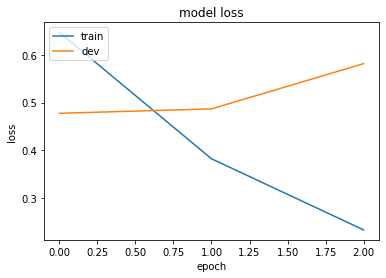

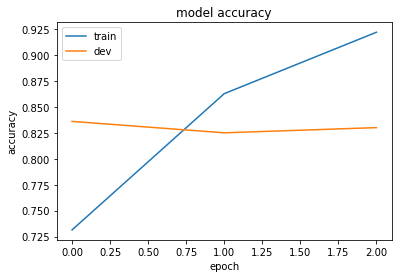

In [43]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# Atribution:
Adapted by Oier Lopez de Lacalle and Ander Barrena